This notebook will be mitigation and the final deliverable, by building a simple app where someone can see:
- the model's overall performance
- the fairness metrics by group
- visualize the disparities

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, true_negative_rate, demographic_parity_ratio

import matplotlib.pyplot as plt

# load and prep
df = pd.read_csv('../data/adult_clean.csv')
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int) # convert str to binary

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# preprocessing
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# train
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Setup complete.")

Model Accuracy: 0.8452
Setup complete.


In [4]:
# Fairness audit function
def run_bias_audit(y_true, y_pred, sensitive_features, group_name):
    mf = MetricFrame(
        metrics={
            'selection_rate': selection_rate,
            'true_positive_rate': true_positive_rate,
            'true_negative_rate': true_negative_rate
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )

    dp_ratio = demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features)

    print(f"\n{'='*50}")
    print(f"BIAS AUDIT: {group_name}")
    print(f"{'='*50}")
    print(mf.by_group)
    print(f"\nDemographic Parity Ratio: {dp_ratio:.4f}")
    if dp_ratio < 0.8:
        print("FAILS 80% rule - potential adverse impact")
    else:
        print("Passes 80% rule")
    return mf, dp_ratio

# run audits
sex_audit, sex_ratio = run_bias_audit(y_test, y_pred, X_test['sex'], 'SEX')
race_audit, race_ratio = run_bias_audit(y_test, y_pred, X_test['race'], 'RACE')


BIAS AUDIT: SEX
        selection_rate  true_positive_rate  true_negative_rate
sex                                                           
Female        0.077793            0.476584            0.978865
Male          0.260976            0.617882            0.896893

Demographic Parity Ratio: 0.2981
FAILS 80% rule - potential adverse impact

BIAS AUDIT: RACE
                    selection_rate  true_positive_rate  true_negative_rate
race                                                                      
Amer-Indian-Eskimo        0.088889            0.538462            0.987013
Asian-Pac-Islander        0.275194            0.722222            0.897849
Black                     0.091885            0.450450            0.962861
Other                     0.062500            0.222222            0.957746
White                     0.214038            0.600393            0.923023

Demographic Parity Ratio: 0.2271
FAILS 80% rule - potential adverse impact


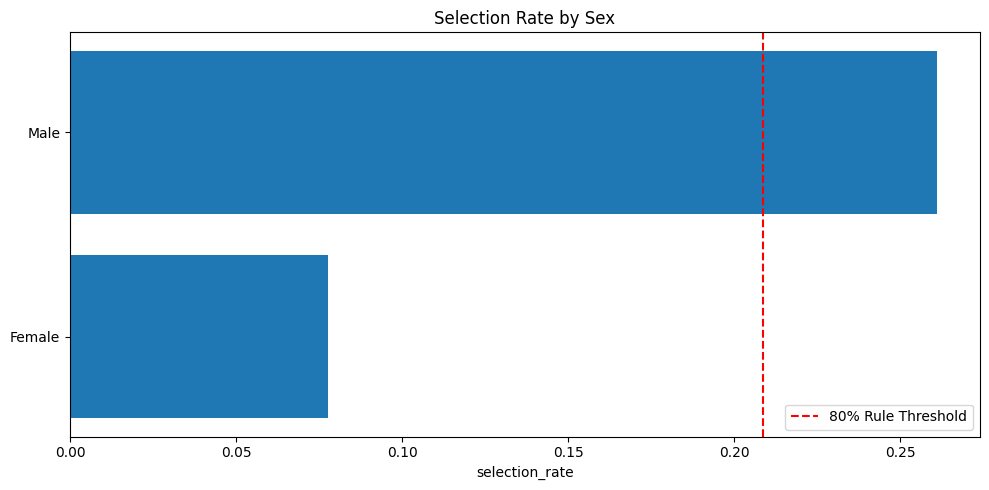

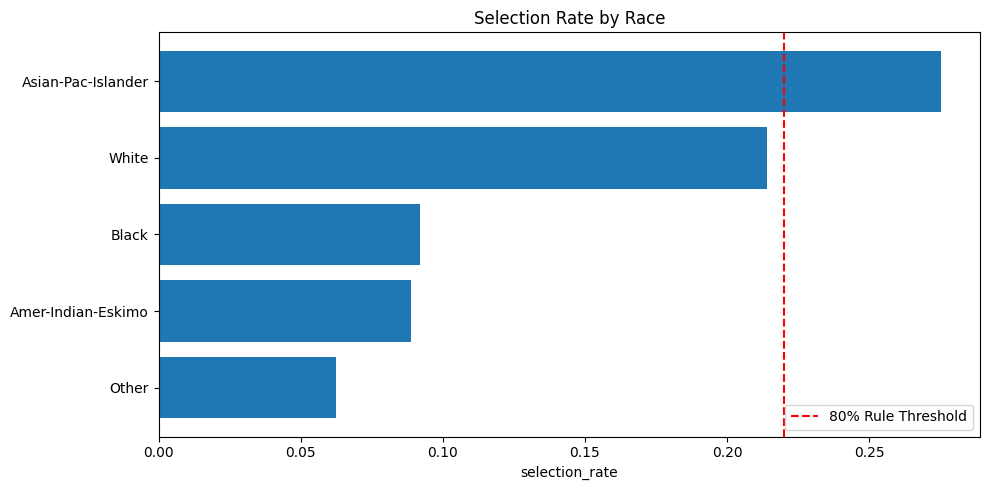

In [5]:
def plot_fairness_comparison(metric_frame, metric_name, title):
    """Bar chart comparing a metric across groups"""

    data = metric_frame.by_group[metric_name].sort_values()

    plt.figure(figsize=(10,5))
    bars = plt.barh(data.index, data.values)
    plt.axvline(x=data.values.max() * 0.8, color='red', linestyle='--', label='80% Rule Threshold')
    plt.xlabel(metric_name)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# visualize selection rates
plot_fairness_comparison(sex_audit, 'selection_rate', 'Selection Rate by Sex')
plot_fairness_comparison(race_audit, 'selection_rate', 'Selection Rate by Race')